In [ ]:
data_location = 'sqlite:///data.db'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import pickle

In [ ]:
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:
ohlc = pd.read_sql('SELECT * FROM ohlc', data_location)
ohlc.shape

(11627, 9)

In [ ]:
ohlc.head()

,ts,open,high,low,close,volume,volumeUSD,token,chain
0,2021-11-01 00:00:00,61421.37,61669.14,61239.60,61343.68,256.433869,1.575751e+07,BTC,BTC
1,2021-11-01 01:00:00,61346.17,61709.82,61171.22,61610.93,332.481185,2.044558e+07,BTC,BTC
2,2021-11-01 02:00:00,61610.94,61779.87,61299.89,61333.17,314.250720,1.935390e+07,BTC,BTC
3,2021-11-01 03:00:00,61333.17,61457.28,60050.00,60589.06,1059.931358,6.414625e+07,BTC,BTC
4,2021-11-01 04:00:00,60590.23,60655.00,59752.92,59971.89,621.419878,3.744744e+07,BTC,BTC


In [ ]:
ohlc.describe()

,open,high,low,close,volume,volumeUSD
count,11627.000000,11627.000000,11627.000000,11627.000000,1.162700e+04,1.162700e+04
mean,5708.198992,5737.512791,5676.641523,5706.967946,7.782893e+05,9.847622e+06
std,16518.161143,16599.532113,16430.972527,16514.731530,2.057505e+06,1.769057e+07
min,0.999900,1.000000,0.995100,0.999900,6.713000e+00,1.960784e+03
25%,4.555900,4.611000,4.496050,4.554350,2.565695e+03,9.664755e+05
50%,92.590000,93.710000,91.000000,92.600000,4.624230e+04,3.420994e+06
75%,307.924500,309.700000,305.501000,307.796500,1.768436e+05,1.068309e+07
max,68638.470000,69000.000000,68456.500000,68639.630000,3.978895e+07,3.988035e+08


In [ ]:
tokens = ohlc.token.unique()

In [62]:
def df_merge(left, right):
    return pd.merge(left, right, on='ts', how='inner')

X = reduce(df_merge, [
    (lambda df: 
    (
        df
        .assign(
            vol=vol_ohlc(df),
            ret=df.close.pct_change()
        )[['ts', 'vol', 'ret']]
        .rename(columns={
            col: f'{col}_{token}' for col in ['ts', 'vol', 'ret'] if col != 'ts'
        })
    ))(ohlc[ohlc.token == token])
    for token in tokens
]).set_index('ts')

In [63]:
X.shape

(1057, 22)

In [64]:
X = X.dropna(axis=0)
X.tail()

,vol_BTC,ret_BTC,vol_ETH,ret_ETH,vol_USDT,ret_USDT,vol_SOL,ret_SOL,vol_ADA,ret_ADA,vol_DOT,ret_DOT,vol_AVAX,ret_AVAX,vol_ATOM,ret_ATOM,vol_CRV,ret_CRV,vol_AAVE,ret_AAVE,vol_COMP,ret_COMP
ts,,,,,,,,,,,,,,,,,,,,,,
2021-12-14 20:00:00,0.136358,0.004810,0.158369,0.005961,0.002463,0.0001,0.216740,0.002798,0.225286,0.014437,0.225643,0.008737,0.239258,0.008227,0.254118,-0.000471,0.255464,0.003049,0.207758,0.009387,0.284268,0.006813
2021-12-14 21:00:00,0.142237,0.019797,0.170096,0.016737,0.002652,0.0000,0.218492,0.025892,0.224116,0.012141,0.228601,0.020472,0.241603,0.019207,0.254350,0.019303,0.263456,0.021277,0.222014,0.022490,0.281497,0.017473
2021-12-14 22:00:00,0.151148,0.010414,0.172081,0.004623,0.002684,0.0000,0.246122,0.015624,0.232362,0.009295,0.242160,0.009645,0.268875,0.026851,0.253472,0.012933,0.270895,0.023810,0.220598,0.006242,0.275083,0.009868
2021-12-14 23:00:00,0.149424,-0.000302,0.170257,-0.003195,0.002823,0.0001,0.238235,-0.010027,0.231115,-0.000157,0.234116,-0.002675,0.301778,0.032506,0.245708,-0.009576,0.268758,-0.011628,0.219474,-0.003013,0.271229,-0.000864
2021-12-15 00:00:00,0.143079,-0.001448,0.159883,-0.000641,0.002816,0.0000,0.228867,0.002517,0.220068,-0.007715,0.220348,-0.002682,0.296444,0.005576,0.234522,-0.003223,0.242546,-0.002941,0.213360,0.001659,0.246067,-0.001027


In [65]:
y = X.ret_SOL.shift(-1)[:-1]
X = X[:-1]

In [66]:
X.shape

(1046, 22)

In [67]:
y.shape

(1046,)

In [68]:
y.describe()


count    1046.000000
mean       -0.000183
std         0.011983
min        -0.053429
25%        -0.007441
50%        -0.000519
75%         0.006684
max         0.048298
Name: ret_SOL, dtype: float64

In [69]:
from pandas.plotting import scatter_matrix, autocorrelation_plot

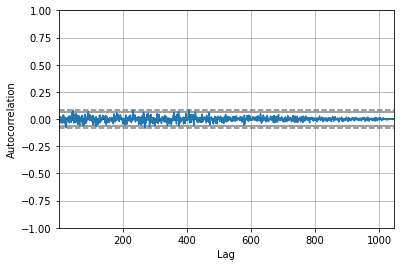

In [70]:
autocorrelation_plot(y[1:])


In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.model_selection import learning_curve

In [72]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]


In [73]:
def evaluate_model(model, X, y, test_size=0.2):
    cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
    scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
    
    return np.mean(cross_validate(model, X, y, cv=cv, scoring=scorer, n_jobs=-1)['test_score'])

In [74]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['ret_SOL'])),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.013684637128091547

In [75]:
pipeline = Pipeline([
    ('feature_selector', FeatureSelector(['ret_SOL'])),
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])

evaluate_model(pipeline, X, y)

-0.011355964602440365

In [76]:
pipeline = Pipeline([
    #('feature_selector', FeatureSelector(['ret_SOL'])),
    #('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('model', DecisionTreeRegressor(random_state=0))
])

evaluate_model(pipeline, X, y)

-0.01364374928308983

In [77]:
pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=1)),
    ('model', Ridge(alpha=1.1))
])

evaluate_model(pipeline, X, y)

-0.008483872897977288

In [ ]:
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('model', Ridge())
])


test_size = 0.2
cv = TimeSeriesSplit(n_splits=int(y.shape[0] * test_size), test_size=1)
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

search = GridSearchCV(pipeline, {
    'pca__n_components': [1, 5, 10, 20, 22],
    'model__alpha': [0.1, 0.5,  1.]
}, scoring=scorer, refit=True, cv=cv, n_jobs=-1)
search.fit(X, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=209, test_size=1),
             estimator=Pipeline(steps=[('impute',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scale', StandardScaler()),
                                       ('pca', PCA(n_components=5)),
                                       ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.1, 0.5, 1.0],
                         'pca__n_components': [1, 5, 10, 20, 22]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False))

In [ ]:
search.best_params_

{'model__alpha': 1.0, 'pca__n_components': 1}

In [ ]:
best_model = search.best_estimator_


In [ ]:
evaluate_model(best_model, X, y)

-0.00850864964744906

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

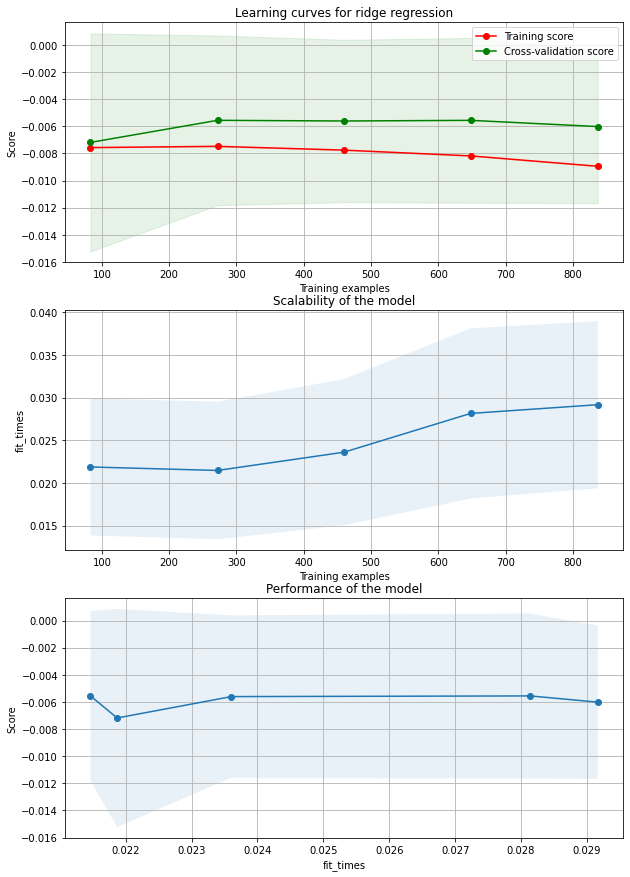

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning curves for ridge regression"

plot_learning_curve(
    best_model, title, X, y, axes=axes, cv=cv, n_jobs=4, scoring=scorer
)